In [16]:
class Bot():
    def __init__(self,strategy) -> None:
        self.strategy=strategy
        if self.strategy=="kris":
            self.history=["R"]
        if self.strategy=="mrugesh":
            self.history=["R" for i in range(10)]
        if self.strategy=="quincy":
            self.history=[]
        if self.strategy=="abbey":
            self.history=["R","R"]
            self.play_order={
                "RR": 0,
                "RP": 0,
                "RS": 0,
                "PR": 0,
                "PP": 0,
                "PS": 0,
                "SR": 0,
                "SP": 0,
                "SS": 0,
          }
    
    def play(self,context):
        s=""
        if self.strategy=="mrugesh":
            for i in range(len(context)):
                s=s+self._mrugesh()
                self.update_history(context[i])
            
        elif self.strategy=="kris":
            for i in range(len(context)):
                s=s+self._kris()
                self.update_history(context[i])
            
        elif self.strategy=="quincy":
            for i in range(len(context)):
                s=s+self._quincy()
                self.update_history(context[i])
        elif self.strategy=="abbey":
            for i in range(len(context)):
                s=s+self._abbey()
                self.update_history(context[i])
        return s

    def update_history(self,move):
        self.history.append(move)

    def _mrugesh(self):
        last_ten=self.history[-10:]
        most_frequent = max(set(last_ten), key=last_ten.count)

        ideal_response = {'P': 'S', 'R': 'P', 'S': 'R'}
        return ideal_response[most_frequent]
    
    def _kris(self):
        ideal_response = {'P': 'S', 'R': 'P', 'S': 'R'}
        return ideal_response[self.history[-1]]
    
    def _quincy(self): #дает одни и теже ответы по кругу
        choices=["R","R","P","P","S"]

        return choices[len((self.history))%len(choices)]
    
    def _abbey(self): # выбирает самое популярное сочетание ходов и отвечает на него
        last_two="".join(self.history[-2:])
        self.play_order[last_two] += 1

        potential_plays = [
            self.history[-1] + "R",
            self.history[-1] + "P",
            self.history[-1] + "S",
        ]

        sub_order = {k: self.play_order[k] for k in potential_plays if k in self.play_order}

        prediction = max(sub_order, key=sub_order.get)[-1:]

        ideal_response = {'P': 'S', 'R': 'P', 'S': 'R'}

        return ideal_response[prediction]




In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random


# Создаем словарь символов
chars = sorted(set("RPS"))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

# Подготовка последовательности символов и меток
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[ch] for ch in seq]
    return torch.tensor(idxs, dtype=torch.long)

# Архитектура модели LSTM
class LSTMTextGenerator(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size):
        super(LSTMTextGenerator, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.RNN(embedding_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, output_size)
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        hidden = self.hidden(lstm_out.view(len(sentence), -1))
        
        return hidden

# Подготовка данных и создание модели
EMBEDDING_DIM = 3
HIDDEN_DIM =  64
EPOCHS=2000
model = LSTMTextGenerator(EMBEDDING_DIM, HIDDEN_DIM, len(chars), len(chars))
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели

games_ahead=8
history="R"*(games_ahead+1) #initial history ,играет бот
bot=Bot(strategy="abbey")

def get_antipos(context):
    ideal_response = {'P': 'S', 'R': 'P', 'S': 'R'}
    ans=""
    for i in context:
        ans=ans+ideal_response[i]
    return ans

loss_history=[]
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    #батча как такового нет ,есть количество игр которые наперед играет агент
    
    inputs = prepare_sequence(history[-games_ahead-1:-1], char_to_ix)
    targets = prepare_sequence(history[-games_ahead:], char_to_ix)  # Предсказание следующего символа
    
    optimizer.zero_grad()

    outputs = model(inputs)
    loss = loss_function(outputs, targets)
    loss.backward()
    optimizer.step()
    total_loss = loss.item()


    #предсказали->перевернули-> записали ответ
    outputs_str=""
    for i in range(games_ahead):
        output_dist = F.softmax(outputs[i], dim=0)
        top_i = torch.argmax(output_dist).item()
        outputs_str += ix_to_char[top_i]
        

    history=history+bot.play(get_antipos(outputs_str))
    
    loss_history.append(loss.item())
    if (epoch+1) % 200 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')




Epoch 200, Loss: 0.8055217266082764
Epoch 400, Loss: 0.6382813453674316
Epoch 600, Loss: 0.43876057863235474
Epoch 800, Loss: 1.369691014289856
Epoch 1000, Loss: 1.1181474924087524
Epoch 1200, Loss: 0.7399986982345581
Epoch 1400, Loss: 1.2973328828811646
Epoch 1600, Loss: 1.3035556077957153
Epoch 1800, Loss: 0.9274562001228333
Epoch 2000, Loss: 0.5831347703933716


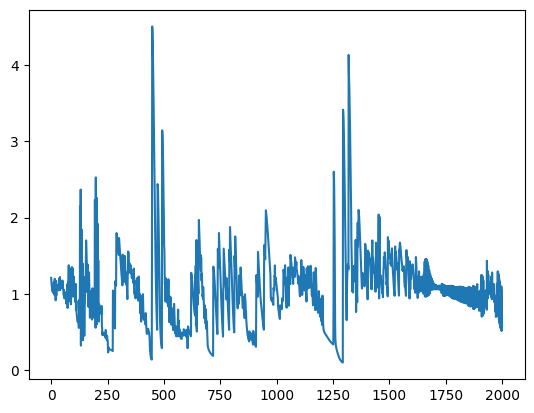

In [18]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot([i for i in range(EPOCHS)],loss_history)

In [19]:
def decode(x):
    _={"R":0,"P":1,"S":2}
    return _[x]

def encode(x):
    _={0:"R",1:"P",2:"S"}
    return _[x]

def decide_winner(x,y,decoded=True):
    if decoded:
        winning_situations = [[0, 2], [2, 1], [1, 0]]
        if [x, y] in winning_situations:
            return 1
        elif x == y:
            return 0
        else:
            return -1
    else:
        x,y=decode(x),decode(y)
        winning_situations = [[0, 2], [2, 1], [1, 0]]
        if [x, y] in winning_situations:
            return 1
        elif x == y:
            return 0
        else:
            return -1
        


# сыграем 1000 игр с полученной моделью

model.train()
actual_history="RPSRPSRPS" #history of bot moves
generated=actual_history
hidden = None
last_player_move=get_antipos(generated[-1])

stats={"player_wins":0,"bot_wins":0,"tie":0}

win_or_lose="1"*9

for _ in range(1,1001):  
    input = prepare_sequence(actual_history, char_to_ix)
    output = model(input)
    output_dist = F.softmax(output[-1], dim=0)
    top_i = torch.argmax(output_dist).item()
    generated += ix_to_char[top_i]
    #предсказали->перевернули->записали ответ
    #последний ход бота в
    
    player_move=get_antipos(generated[-1])

    bot_move=bot.play(last_player_move)

    #print(f"game {_} player {player_move} ")
    
    #print(f"Player: {player_move}",f"Bot:{bot_move}")
    
    actual_history+=bot_move
    last_player_move=player_move

    if decide_winner(player_move,bot_move,decoded=False)==1:
        stats["player_wins"]+=1
        win_or_lose=win_or_lose+"1"
    elif decide_winner(player_move,bot_move,decoded=False)==0:
        stats["tie"]+=1
        win_or_lose=win_or_lose+"2"
    else:
        stats["bot_wins"]+=1
        win_or_lose=win_or_lose+"0"
    if _%100==0:
        print(stats)
        print(f"winrate=={stats['player_wins']/_}")

{'player_wins': 1, 'bot_wins': 98, 'tie': 1}
winrate==0.01
{'player_wins': 1, 'bot_wins': 198, 'tie': 1}
winrate==0.005
{'player_wins': 1, 'bot_wins': 298, 'tie': 1}
winrate==0.0033333333333333335
{'player_wins': 1, 'bot_wins': 398, 'tie': 1}
winrate==0.0025
{'player_wins': 1, 'bot_wins': 498, 'tie': 1}
winrate==0.002
{'player_wins': 1, 'bot_wins': 598, 'tie': 1}
winrate==0.0016666666666666668
{'player_wins': 1, 'bot_wins': 698, 'tie': 1}
winrate==0.0014285714285714286
{'player_wins': 1, 'bot_wins': 798, 'tie': 1}
winrate==0.00125
{'player_wins': 1, 'bot_wins': 898, 'tie': 1}
winrate==0.0011111111111111111
{'player_wins': 1, 'bot_wins': 998, 'tie': 1}
winrate==0.001


In [20]:
print(f"gener       {generated[9:]}") #первые девять ненастоящие
print(f"actual      {actual_history[9:]}")
print(f"win_or_lose {win_or_lose[9:]}")
print(len(bot.history))

gener       PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP